In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import plotnine as gg
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
import seaborn as sns
from model import loss
from model import score_network
from model import ipa_pytorch
import tree
from data import rosetta_data_loader
import subprocess
from data import digs_data_loader
from data import all_atom
from openfold.data import data_transforms
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from openfold.np import residue_constants
from scipy.spatial.transform import Rotation
import pandas as pd
pd.set_option('display.max_colwidth', None)

from matplotlib.gridspec import GridSpec
import biotite.sequence as seq
import biotite.sequence.io.fasta as fasta
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
import biotite.database.entrez as entrez
import biotite

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [3]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(au)
importlib.reload(all_atom)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(score_network)
importlib.reload(ipa_pytorch)
importlib.reload(inference_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [ ]:
# Load model
base_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion'
inference_conf_path = os.path.join(base_dir, 'config/inference.yaml')
inference_conf = OmegaConf.load(inference_conf_path)
inference_conf.ckpt_dir = os.path.join(
    base_dir,
    # 'pkl_jar/ckpt/sweep_0/24D_10M_2022Y_16h_25m_04s',
    'pkl_jar/ckpt/sweep_1/24D_10M_2022Y_16h_25m_04s'
)


inference_conf.default_conf_path = os.path.join(
    base_dir, 'config/base.yaml')
inference_conf.output_dir = os.path.join(
    base_dir, 'results')
# inference_conf.num_t = 500
# inference_conf.min_t = 1e-3
# print(OmegaConf.to_yaml(inference_conf))

# Set up sampler
sampler = inference_se3_diffusion.Sampler(
    inference_conf,
    conf_overrides={'experiment': {'eval_batch_size': 1}}
)
train_loader, valid_loader = sampler.exp.create_rosetta_dataset(0, 1)
train_csv = train_loader.dataset.csv

### Scaffold valid set

In [ ]:
# Sample an example
data_iter = iter(valid_loader)

In [1]:
next_item = next(data_iter)

NameError: name 'data_iter' is not defined

In [260]:
train_csv['index'] = list(range(len(train_csv)))

In [263]:
train_csv.groupby('modeled_seq_len').sample(8, replace=True)


pdb_name  \
6661      2xmf   
12511     5fwb   
34703     7ner   
11343     5n35   
12511     5fwb   
...        ...   
19106     4drq   
29887     1c4w   
50943     3o5l   
38686     3fq2   
29887     1c4w   

                                                               processed_path  \
6661   /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/xm/2xmf.pkl   
12511  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/fw/5fwb.pkl   
34703  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/ne/7ner.pkl   
11343  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/n3/5n35.pkl   
12511  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/fw/5fwb.pkl   
...                                                                       ...   
19106  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/dr/4drq.pkl   
29887  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/c4/1c4w.pkl   
50943  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/o5/3o5l.pkl   
38686  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/fq/3fq2.pkl   
29887  /data/rsg/chemistry/jyim/large_data/processed_pdb_protdiff/c4/1c4w.pkl   

                                                                   raw_path  \
6661   /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/xm/2xmf.cif   
12511  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/fw/5fwb.cif   
34703  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/ne/7ner.cif   
11343  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/n3/5n35.cif   
12511  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/fw/5fwb.cif   
...                                                                     ...   
19106  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/dr/4drq.cif   
29887  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/c4/1c4w.cif   
50943  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/o5/3o5l.cif   
38686  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/fq/3fq2.cif   
29887  /data/rsg/chemistry/jyim/large_data/pdb/30_08_2021/mmCIF/c4/1c4w.cif   

      oligomeric_count oligomeric_detail  resolution   structure_method  \
6661                 1         monomeric        1.50  x-ray diffraction   
12511                1         monomeric        1.50  x-ray diffraction   
34703                1         monomeric        1.55  x-ray diffraction   
11343                1         monomeric        2.20  x-ray diffraction   
12511                1         monomeric        1.50  x-ray diffraction   
...                ...               ...         ...                ...   
19106                1         monomeric        1.00  x-ray diffraction   
29887                1         monomeric        1.84  x-ray diffraction   
50943                1         monomeric        1.30  x-ray diffraction   
38686                1         monomeric        1.68  x-ray diffraction   
29887                1         monomeric        1.84  x-ray diffraction   

       num_chains quaternary_category  seq_len  modeled_seq_len  coil_percent  \
6661            1             homomer      147               60      0.466667   
12511           1             homomer      133               60      0.483333   
34703           1             homomer      110               60      0.483333   
11343           1             homomer       96               60      0.283333   
12511           1             homomer      133               60      0.483333   
...           ...                 ...      ...              ...           ...   
19106           1             homomer      328              128      0.476562   
29887           1             homomer      268              128      0.398438   
50943           1             homomer      290              128      0.476562   
38686           1             homomer      208              128      0.453125   
29887           1             homomer      268              128      0.3984

In [267]:
len(train_csv['modeled_seq_len'].unique())

69

In [1]:
base_dir

NameError: name 'base_dir' is not defined

### Manually set scaffold

In [213]:
design_pdb_file = os.path.join(
    base_dir,
    'inpainting/targets/rsv_Jue_design.pdb'
    # 'inpainting/targets/1PRW-EF-hand_1motif_98_rd2.pdb'
)
design_pdb_feats = du.parse_pdb_feats('design', design_pdb_file)
chain_feats = {
    'aatype': torch.tensor(design_pdb_feats['aatype']).long(),
    'all_atom_positions': torch.tensor(design_pdb_feats['atom_positions']).double(),
    'all_atom_mask': torch.tensor(design_pdb_feats['atom_mask']).double()
}

In [214]:
chain_feats = data_transforms.atom37_to_frames(chain_feats)
chain_feats = data_transforms.make_atom14_masks(chain_feats)
chain_feats = data_transforms.make_atom14_positions(chain_feats)
chain_feats = data_transforms.atom37_to_torsion_angles()(chain_feats)

In [222]:
res_mask = design_pdb_feats['bb_mask']
fixed_mask = np.zeros_like(res_mask)
fixed_mask[16:34] = 1.
# fixed_mask[31:43] = 1.
diffuse_mask = 1 - fixed_mask
aatype_impute = sampler.diffuser.seq_diffuser.one_hot(design_pdb_feats['aatype'])
rigids_impute = ru.Rigid.from_tensor_4x4(chain_feats['rigidgroups_gt_frames'])[:, 0]
psi_impute = du.move_to_np(chain_feats['torsion_angles_sin_cos'])

In [223]:
# Sample
num_samples = 10
all_designs = []
for _ in range(num_samples):
    sample_out = sampler.sample(
        res_mask=res_mask,
        fixed_mask=fixed_mask,
        aatype_impute=aatype_impute,
        rigids_impute=rigids_impute,
        psi_impute=psi_impute,
    )
    all_designs.append(sample_out)

### Write all sequences out to FASTA

In [245]:
all_seqs = [du.aatype_to_seq(np.argmax(aatype_impute, axis=-1))]
fasta_seq_ids = ['wild_type']
for i,design_out in enumerate(all_designs):
    seq_traj = design_out['seq_traj']
    all_seqs.append(''.join(seq_traj[0]))
    fasta_seq_ids.append(f'design_{i+1}')

In [246]:
fasta_path = os.path.join(
    base_dir,
    'inpainting/designs/design_seqs'
)
saved_path = sampler.save_fasta(
    all_seqs,
    fasta_seq_ids,
    fasta_path,
    override_save_path=True
)

In [247]:
seq_subset = [seq.ProteinSequence(seq_str) for seq_str in all_seqs]
alignment = align.Alignment(seq_subset, align.Alignment.trace_from_strings(seq_subset))

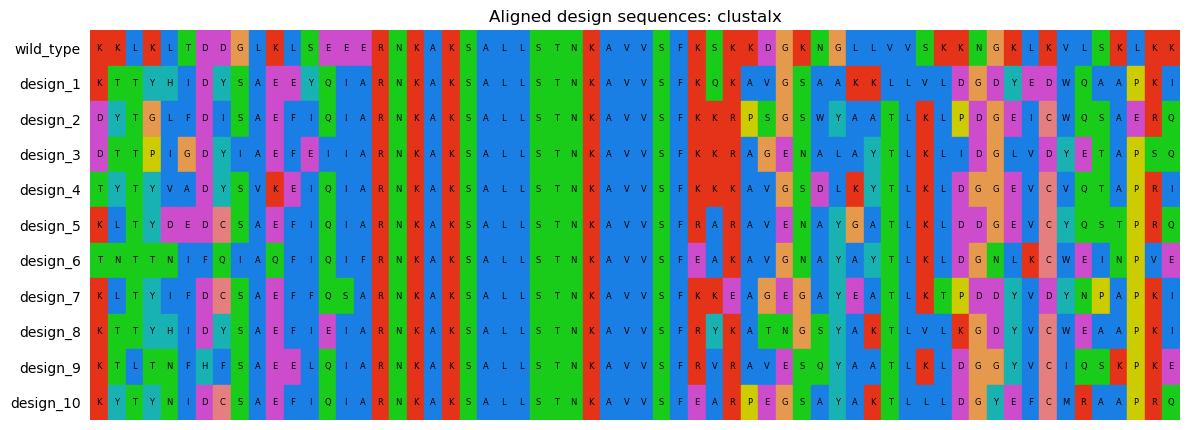

In [248]:
color_scheme = 'clustalx'

fig = plt.figure(figsize=(12.0, 0.4*len(fasta_seq_ids)))
ax = plt.subplot(1, 1, 1)
graphics.plot_alignment_type_based(
    ax,
    alignment,
    labels=fasta_seq_ids,
    symbols_per_line=seq_traj.shape[1],
    color_scheme=color_scheme,
    color_symbols=False,
    symbol_size=6
)
ax.set_title(f'Aligned design sequences: {color_scheme}')
fig.tight_layout()
plt.show()

### Run self-consistency

In [250]:
saved_path

'/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_seqs.fasta'

In [256]:
from analysis import metrics

In [251]:
# pdb_path = '/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_127_diffuse_100_inpaint_2id9_sde_3.pdb'
# fasta_path = '/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_127_diffuse_100_inpaint_2id9_sde_of.fasta'
# sc, plddt = sampler.run_self_consistency(pdb_path, fasta_path)

In [254]:
path_1 = '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_8_len_62_diffuse_071_sde_1.pdb'
path_2 = '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_8.pdb'

In [257]:
sample_feats = du.parse_pdb_feats('sample', path_1)
of_feats = du.parse_pdb_feats('sample', path_2)
sample_seq = du.aatype_to_seq(sample_feats['aatype'])
_, tm_score = metrics.calc_tm_score(
    sample_feats['bb_positions'], of_feats['bb_positions'],
    sample_seq, sample_seq)

In [258]:
tm_score

0.5390745526481625

In [252]:
output_dir = os.path.dirname(saved_path)
process = subprocess.Popen([
    'omegafold',
    saved_path,
    output_dir,
])

INFO:root:Loading weights from /data/rsg/chemistry/jyim/third_party/omegafold/release1.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_seqs.fasta
INFO:root:Predicting 1th chain in /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_seqs.fasta
INFO:root:62 residues in this chain.
INFO:root:Finished prediction in 4.83 seconds.
INFO:root:Saving prediction to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/wild_type.pdb
INFO:root:Saved
INFO:root:Predicting 2th chain in /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_seqs.fasta
INFO:root:62 residues in this chain.
INFO:root:Finished prediction in 3.12 seconds.
INFO:root:Saving prediction to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_1.pdb
INFO:root:Saved
INFO:root:Predicting 3th chain in /data/rsg/chemistry/jyim/projects/protein_diffusion/inpaint

### Write designed structure to PDB

In [228]:
all_seqs = []
for i,design_out in enumerate(all_designs):

    bb_traj = design_out['prot_traj']
    trans_traj = design_out['trans_traj']
    design_path = os.path.join(
        base_dir,
        f'inpainting/designs/design_{i}'
    )
    sampler.save_traj(
        bb_traj,
        trans_traj,
        aatype,
        res_mask,
        diffuse_mask,
        file_prefix=design_path,
        override_save_path=True
    )

INFO: Saved sample to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_0_len_62_diffuse_071_sde_1.pdb
INFO: Saved trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_0_len_62_diffuse_071_sde_bb_traj_1.pdb
INFO: Saved x0 trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_0_len_62_diffuse_071_sde_x0_traj_1.pdb
INFO: Saved sample to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_1_len_62_diffuse_071_sde_1.pdb
INFO: Saved trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_1_len_62_diffuse_071_sde_bb_traj_1.pdb
INFO: Saved x0 trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_1_len_62_diffuse_071_sde_x0_traj_1.pdb
INFO: Saved sample to /data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/designs/design_2_len_62_diffuse_071_sde_1.pdb
INFO: Saved trajectory to /da

### Analyze sequence trajectory

In [233]:
# Generate fasta of sequence trajectories
desin_traj = all_designs[1]
seq_traj = desin_traj['seq_traj']
all_traj_seqs = [''.join(x[0].tolist()) for x in np.array_split(seq_traj, seq_traj.shape[0])]
fasta_seq_names = [f't={x:.2f}' for x in np.linspace(1e-3, 1.0, seq_traj.shape[0])]

In [234]:
# Save fasta
fasta_path = os.path.join(
    base_dir,
    'inpainting/designs/seq_traj'
)
saved_path = sampler.save_fasta(
    all_traj_seqs,
    fasta_seq_names,
    fasta_path,
    override_save_path=True
)
fasta_file = fasta.FastaFile.read(saved_path)
sequences = [seq.ProteinSequence(seq_str) for seq_str in fasta_file.values()]

In [235]:
seq_subset = all_traj_seqs[0::10]
label_subset = fasta_seq_names[0::10]

gt_seq = du.aatype_to_seq(np.argmax(aatype_impute, axis=-1))
seq_subset = [gt_seq] + seq_subset
label_subset = ['wildtype'] + label_subset

seq_subset = [seq.ProteinSequence(seq_str) for seq_str in seq_subset]
alignment = align.Alignment(seq_subset, align.Alignment.trace_from_strings(seq_subset))

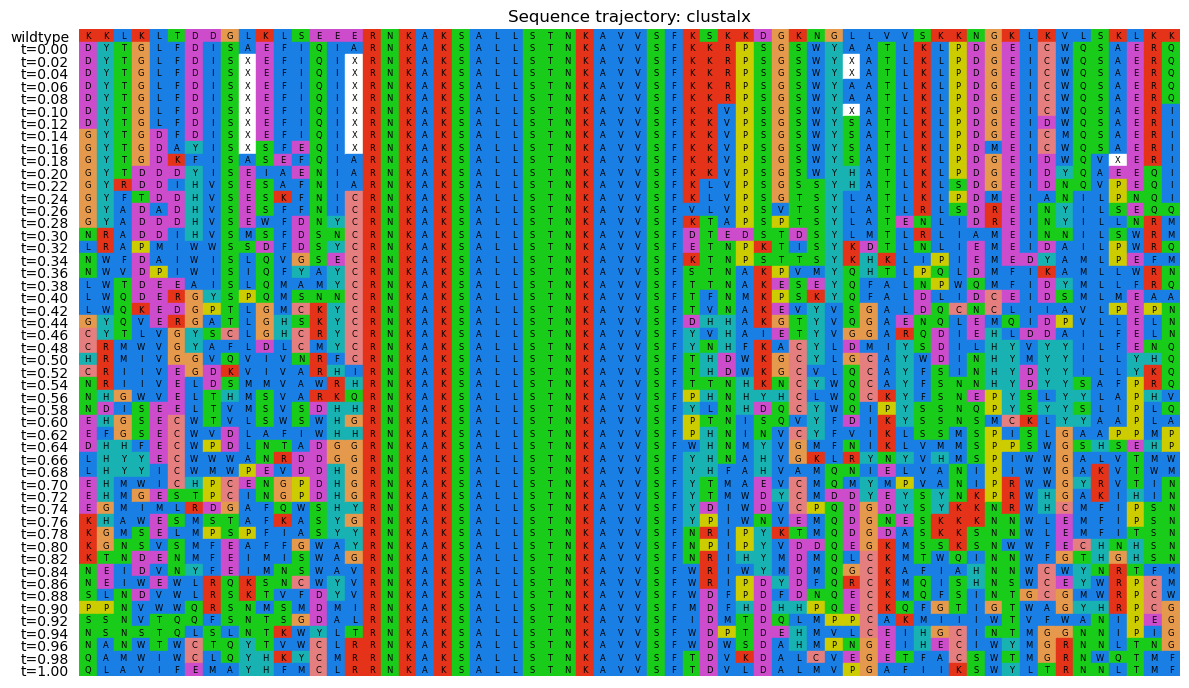

In [236]:
# color_scheme = 'ocean'
color_scheme = 'clustalx'

fig = plt.figure(figsize=(12.0, 7.0))
ax = plt.subplot(1, 1, 1)
graphics.plot_alignment_type_based(
    ax,
    alignment,
    labels=label_subset,
    symbols_per_line=seq_traj.shape[1],
    color_scheme=color_scheme,
    color_symbols=False,
    symbol_size=6
)
ax.set_title(f'Sequence trajectory: {color_scheme}')
fig.tight_layout()
plt.show()

In [ ]:
# Get color scheme names
alphabet = seq.ProteinSequence.alphabet
schemes = [
    "rainbow", "clustalx",
    "flower", "blossom", "spring", "wither", "autumn", "sunset", "ocean",
    "zappo", "taylor", "buried", "hydrophobicity",
    "prophelix", "propstrand", "propturn"
]
count = len(schemes)
# Assert that this example displays all available amino acid color schemes
all_schemes = graphics.list_color_scheme_names(alphabet)
assert set(schemes) == set(all_schemes)


# Visualize each scheme using the example alignment
fig = plt.figure(figsize=(8.0, count*2.0))
gridspec = GridSpec(2, count)
for i, name in enumerate(schemes):
    for j, color_symbols in enumerate([False, True]):
        ax = fig.add_subplot(count, 2, 2*i + j + 1)
        if j == 0:
            ax.set_ylabel(name)
            alignment_part = alignment[:40]
        else:
            alignment_part = alignment[40:]
        graphics.plot_alignment_type_based(
            ax, alignment_part, symbols_per_line=len(alignment_part),
            color_scheme=name, color_symbols=color_symbols, symbol_size=8
        )
fig.tight_layout()
fig.subplots_adjust(wspace=0)
plt.show()

In [ ]:
import biotite.sequence as seq


In [74]:
# Set up all designs.
inpaint_csv = pd.DataFrame({
    'target': [
        'rsv_site_5',
        'ef_hand',
        '6e6r_1_A',
        '6e6r_1_A',
        '6exz_1_A',
        '6exz_1_A',
        '5ci9_1_A',
        '5ci9_1_A',
        '5trv_1_A',
        '5trv_1_A',
    ],
    'motif_contig': [
        '16-34',
        '31-43',
        '23-32',
        '32-43',
        '24-35',
        '32-43',
        '58-68',
        '65-75',
        '42-62',
        '50-60',
    ],
    'file_path': [
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/rsv_Jue_design.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/1PRW-EF-hand_1motif_98_rd2.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/6e6r_1_A.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/6e6r_1_A.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/6exz_1_A.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/6exz_1_A.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/5ci9_1_A.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/5ci9_1_A.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/5trv_1_A.pdb',
        '/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/targets/5trv_1_A.pdb',
    ],
})


In [76]:
inpaint_csv.to_csv('/data/rsg/chemistry/jyim/projects/protein_diffusion/inpainting/contigs.csv')

In [ ]:
pdb_path = '/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_127_diffuse_100_inpaint_2id9_sde_3.pdb'
fasta_path = '/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_127_diffuse_100_inpaint_2id9_sde_of.fasta'
sc, plddt = sampler.run_self_consistency(pdb_path, fasta_path)

In [64]:
sc

0.30243974557571196

In [ ]:
_, tm_score = calc_tm_score(
    sample_feats['bb_positions'], of_feats['bb_positions'], sample_seq, sample_seq)

### Run eval

In [47]:
# Sample an example
data_iter = iter(valid_loader)

In [49]:
eval_dir = os.path.join(base_dir, 'notebooks/eval/')
eval_metrics = sampler.exp.eval_fn(eval_dir, data_iter, 'cuda', num_t=250, min_t=0.2)

In [50]:
eval_metrics.tm_score.mean()

0.39186255143697035

In [ ]:
eval_metrics.head()

In [ ]:
eval_metrics.non_coil_percent.hist()

In [ ]:
eval_metrics[['tm_score', 'sequence_similarity', 'sample_path']]

In [ ]:
p = gg.ggplot(gg.aes(x='tm_score', y='sequence_similarity'), eval_metrics)
(
    p 
    + gg.geom_point()
    + gg.geom_abline(intercept = 0, slope = 1)
    + gg.ylim(0, 1.0)
    + gg.xlim(0, 1.0)
    + gg.labels.ggtitle('Sample TM-score vs. sequence similarity')
)

In [ ]:
ax = eval_metrics.tm_score.hist()
ax.set_title('Native scaffold structure recovery')
ax.set_xlabel('Scaffold TM-score')
ax.set_ylabel('count')

### Visualize data

In [11]:
# data_iter = iter(train_loader)
# next_item = next(data_iter)

# Sample an example
data_iter = iter(valid_loader)
next_item, pdb_names = next(data_iter)

In [12]:
b_idx = 0
trans_0 = next_item['rigids_0'][..., 4:][b_idx]
trans_t = next_item['rigids_t'][..., 4:][b_idx]
fixed_mask_t = next_item['fixed_mask'][b_idx]
res_mask_t = next_item['res_mask'][b_idx]
t = next_item['t'][b_idx]

tensor(1.)
tensor([1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0.], dtype=torch.float64)


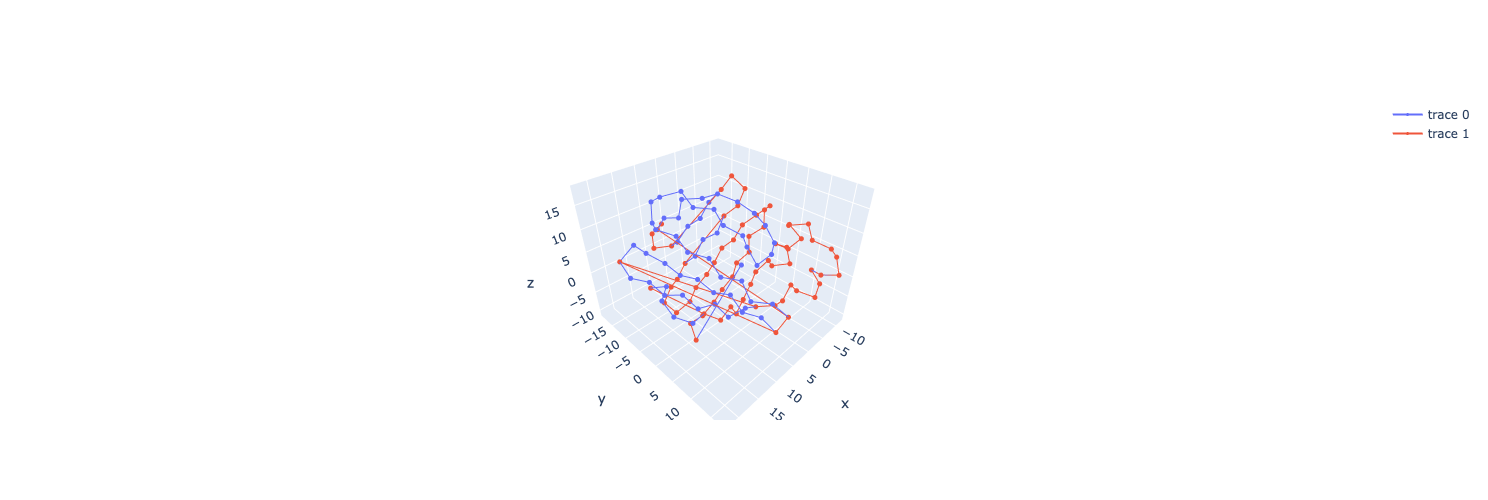

In [13]:
print(t)
print(fixed_mask_t)
gt_bb_3d = plotting.create_scatter(
    du.move_to_np(trans_0),
    mode='lines+markers', 
    marker_size=3,
    opacity=1.0
)
t_bb_3d = plotting.create_scatter(
    du.move_to_np(trans_t[fixed_mask_t.bool()]),
    mode='lines+markers', 
    marker_size=3,
    opacity=1.0
)
plotting.plot_traces([
    gt_bb_3d, t_bb_3d
])

In [14]:
# Sample an example
data_iter = iter(valid_loader)
next_item, pdb_names = next(data_iter)

In [15]:
# Run sampler
save = True
b_idx = 0
pdb_name = pdb_names[b_idx]
res_mask = next_item['res_mask'][b_idx]
fixed_mask = next_item['fixed_mask'][b_idx]
aatype_impute = next_item['aatype_probs_0'][b_idx]
psi_impute = next_item['torsion_angles_sin_cos'][b_idx]
rigids_impute = ru.Rigid.from_tensor_7(next_item['rigids_0'][b_idx])

fixed_percent = torch.sum(fixed_mask) / torch.sum(res_mask)
diffused_percent = 1 - fixed_percent
print(pdb_name)
print(diffused_percent)
print(torch.sum(res_mask))

# Save both ODE and SDE
sample_out = sampler.sample(
    res_mask=du.move_to_np(res_mask),
    fixed_mask=du.move_to_np(fixed_mask),
    aatype_impute=du.move_to_np(aatype_impute),
    rigids_impute=rigids_impute,
    psi_impute=psi_impute,
    save=save,
    ode=True,
    file_prefix=os.path.join(base_dir, 'notebooks/samples/')
)

sample_out = sampler.sample(
    res_mask=du.move_to_np(res_mask),
    fixed_mask=du.move_to_np(fixed_mask),
    aatype_impute=du.move_to_np(aatype_impute),
    rigids_impute=rigids_impute,
    psi_impute=psi_impute,
    save=save,
    ode=False,
    file_prefix=os.path.join(base_dir, 'notebooks/samples/')
)

1tvq
tensor(0.4480, dtype=torch.float64)
tensor(125., dtype=torch.float64)


INFO: Saved sample to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_125_diffuse_045_ode_1.pdb
INFO: Saved trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_125_diffuse_045_ode_traj_1.pdb
INFO: Saved x0 trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_125_diffuse_045_ode_x0_traj_1.pdb
INFO: Saved sequence to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_125_diffuse_045_ode_of.fasta
INFO: Saved sample to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_125_diffuse_045_sde_1.pdb
INFO: Saved trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_125_diffuse_045_sde_traj_1.pdb
INFO: Saved x0 trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_125_diffuse_045_sde_x0_traj_1.pdb
INFO: Saved sequence to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples

In [ ]:
sc, plddt = sampler.run_self_consistency(pdb_path, fasta_path)

In [16]:
unpad_gt_aatype = aatype_impute[res_mask.bool()]
pred_aatype_prob = aatype_traj[0][res_mask.bool()]
pred_aatype = np.argmax(pred_aatype_prob[:, :-1], axis=-1)
diffuse_mask = du.move_to_np(1 - fixed_mask[res_mask.bool()]).astype(bool)

gt_seq = du.aatype_to_seq(du.move_to_np(torch.argmax(unpad_gt_aatype, dim=-1)))
pred_seq = du.aatype_to_seq(pred_aatype)


In [17]:
match = 0
for i,(pred, gt) in enumerate(zip(pred_seq, gt_seq)):
    if diffuse_mask[i]:
        # print(i, pred, gt)
        match += int(pred == gt)
print(match / np.sum(diffuse_mask))

0.03508771929824561


In [9]:
np.where(diffuse_mask)

(array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  42,  43,  44,  47,  48,  50,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  87,  88,  89,  90,  91,  92, 112, 113, 114,
        115, 116, 117, 118, 119]),)

In [12]:
torch.argmax(unpad_gt_aatype[7])

tensor(14)

Text(95.72222222222221, 0.5, 'Single residue reverse diffusion')

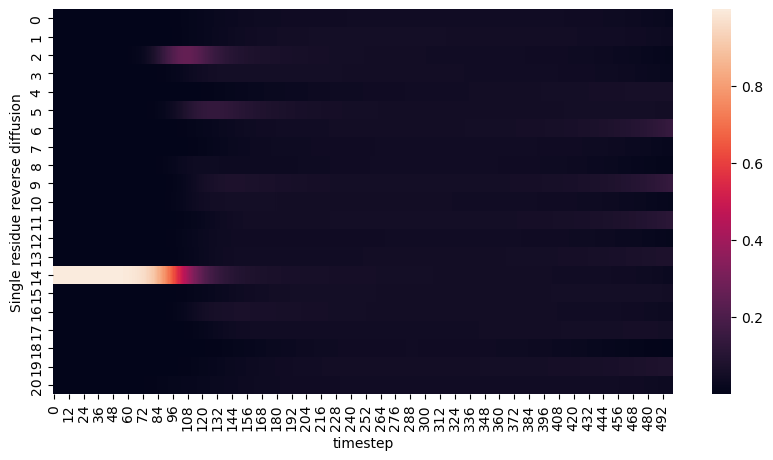

In [14]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(aatype_traj[:, 7].T)
ax.set_xlabel('timestep')
ax.set_ylabel('amino acid')
ax.set_ylabel('Single residue reverse diffusion')

In [228]:
import subprocess
output_dir = os.path.dirname(fasta_path)
process = subprocess.Popen([
    'omegafold',
    fasta_path,
    output_dir,
])

INFO:root:Loading weights from /data/rsg/chemistry/jyim/third_party/omegafold/release1.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./samples/len_112_diffuse_092_of.fasta
INFO:root:Predicting 1th chain in ./samples/len_112_diffuse_092_of.fasta
INFO:root:112 residues in this chain.
INFO:root:Finished prediction in 5.82 seconds.
INFO:root:Saving prediction to ./samples/len_112_diffuse_092_of.pdb
INFO:root:Saved
INFO:root:Done!


## Sample batch

In [ ]:
def sample(idx):
    res_mask = next_item['res_mask'][b_idx]
    fixed_mask = next_item['fixed_mask'][b_idx]
    aatype_impute = next_item['aatype_0'][b_idx]
    psi_impute = next_item['torsion_angles_sin_cos'][b_idx]
    rigid_impute = ru.Rigid.from_tensor_7(next_item['rigids_0'][b_idx])

    fixed_percent = torch.sum(fixed_mask) / fixed_mask.shape[0]
    diffused_percent = 1 - fixed_percent
    print(pdb_name)
    print(diffused_percent)

    rigids_traj, aatype_traj, pdb_path, traj_path, fasta_path = sampler.sample(
        res_mask=res_mask,
        fixed_mask=fixed_mask,
        aatype_impute=aatype_impute,
        rigid_impute=rigid_impute,
        psi_impute=psi_impute,
        save=save,
        add_noise=add_noise,
        file_prefix='notebooks/samples/'
    )

In [ ]:
for b_idx in range(len(pdb_names)):
    print(pdb_names[b_idx])
    _ = sample(b_idx)

In [ ]:
# Run sampler
save = True
add_noise = True
b_idx = 1
pdb_name = pdb_names[b_idx]
res_mask = next_item['res_mask'][b_idx]
fixed_mask = next_item['fixed_mask'][b_idx]
aatype_impute = next_item['aatype_0'][b_idx]
psi_impute = next_item['torsion_angles_sin_cos'][b_idx]
rigid_impute = ru.Rigid.from_tensor_7(next_item['rigids_0'][b_idx])

fixed_percent = torch.sum(fixed_mask) / fixed_mask.shape[0]
diffused_percent = 1 - fixed_percent
print(pdb_name)
print(diffused_percent)

rigids_traj, aatype_traj, pdb_path, traj_path, fasta_path = sampler.sample(
    res_mask=res_mask,
    fixed_mask=fixed_mask,
    aatype_impute=aatype_impute,
    rigid_impute=rigid_impute,
    psi_impute=psi_impute,
    save=save,
    add_noise=add_noise,
    file_prefix='notebooks/samples/'
)

In [217]:
from tmtools import tm_align

In [229]:
def calc_tm_score(pos_1, pos_2, seq_1, seq_2):
    tm_results = tm_align(pos_1, pos_2, seq_1, seq_2)
    return tm_results.tm_norm_chain1, tm_results.tm_norm_chain2 

In [233]:
sample_feats = du.parse_pdb_feats('sample', pdb_path)
of_feats = du.parse_pdb_feats('sample', fasta_path.replace('.fasta', '.pdb'))

In [241]:
of_feats

dict_keys(['atom_positions', 'aatype', 'atom_mask', 'residue_index', 'bb_mask', 'bb_positions'])

In [237]:
sample_seq = du.aatype_to_seq(sample_feats['aatype'])

In [238]:
sample_seq

'AAELGHLKECLGNLKENLYASHWSAYYQFYEPVDAAGVGLHDIHDIYKHPMDLEKMKRKMENRDYTAAAFAAFVRLMFFNCYAKYNPPDHPVYAMAQKVRLVFAAYLADYDE'

In [239]:
_, tm_score = calc_tm_score(
    sample_feats['bb_positions'], of_feats['bb_positions'], sample_seq, sample_seq)

In [240]:
tm_score

0.5041145979696957

### Sample without data

In [ ]:
# Run sampler
batch_size = 4
num_res = 150
res_mask = torch.ones((batch_size, num_res))
save = True
samples_traj = sampler.sample(
    res_mask=res_mask,
    save=save,
    file_prefix='./samples/'
)